Nov.10 2020, Adi Watzman. See v2 for history.  

* (V2 - compare Nov.9, >14PM and export our feedback to send MoT. Large differences - see summary: https://docs.google.com/document/d/1T7FYQaXrROmUB7RN-jAlV1MTPt1vifTotRRs3JOHWw0/edit?usp=sharing.)
* MoT asked to compare more recent dates as 2.8 went through improvements.
* V3 - compare a more recent date XXXXX and export our feedback to send MoT.


======  
Goal:  
Parse 1 day of data to compare Siri 2.7 to 2.8 versions.  
2.7 is the current "production" version for us, base on siri_retreiver Java code that queries MoT's servers for all last stops.   
2.8 is a new version, that allows MUCH simpler query, and get all currently driving buses without any quering hack.   
However, we want to make sure we get the same data with both versions before we switch to 2.8 for "production".

The data was manually downloaded from our S3 server.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [3]:
import datetime as dt

In [4]:
data_dir = '/Users/awatzman/Documents/OpenBusDocuments/data/' \
           '2020-10-12_compare_siri_2.7_2.8'
siri_27_dir = join(data_dir, 'siri_27_2021-02-14') # csv.gz files
siri_28_dir = join(data_dir, 'siri_28_2021-02-14') # tar.gz file per hour, each with ~120 json.gz files


In [5]:
! ls $siri_27_dir | grep csv | wc -l

      18


In [6]:
! ls $siri_28_dir | grep tar | wc -l

      24


In [7]:
! ls $siri_28_dir | grep tar 

2021-02-14_00.tar.gz
2021-02-14_01.tar.gz
2021-02-14_02.tar.gz
2021-02-14_03.tar.gz
2021-02-14_04.tar.gz
2021-02-14_05.tar.gz
2021-02-14_06.tar.gz
2021-02-14_07.tar.gz
2021-02-14_08.tar.gz
2021-02-14_09.tar.gz
2021-02-14_10.tar.gz
2021-02-14_11.tar.gz
2021-02-14_12.tar.gz
2021-02-14_13.tar.gz
2021-02-14_14.tar.gz
2021-02-14_15.tar.gz
2021-02-14_16.tar.gz
2021-02-14_17.tar.gz
2021-02-14_18.tar.gz
2021-02-14_19.tar.gz
2021-02-14_20.tar.gz
2021-02-14_21.tar.gz
2021-02-14_22.tar.gz
2021-02-14_23.tar.gz


# Read 2.8 files

In [8]:
from siri_parser import read_siri28_file, read_siri28_files, SIRI28_TYPES

In [23]:
# %%time
# df_28_day = read_siri28_files(siri_28_dir, max_files=None, suf='.json')
# df_28_day.shape

/Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2021-02-14/22/siri_snap_normal_2021-02-14T220901.json Expecting value: line 1 column 1 (char 0)
CPU times: user 13min 16s, sys: 17 s, total: 13min 33s
Wall time: 13min 34s


(9665344, 17)

In [24]:
# df_28_day.to_feather('df_28_20210214.feather')

In [25]:
df_28_day = pd.read_feather('df_28_20210214.feather')
df_28_day.shape

(9665344, 17)

In [26]:
dt_cols = [col for col in df_28_day.columns 
           if pd.api.types.is_datetime64_ns_dtype(df_28_day[col])]
df_28_day[dt_cols].dtypes

recorded_at_time               datetime64[ns, pytz.FixedOffset(120)]
origin_aimed_departure_time    datetime64[ns, pytz.FixedOffset(120)]
response_timestamp             datetime64[ns, pytz.FixedOffset(120)]
dtype: object

In [27]:
# remove timezone data, keep the time as-is to compare to 2.7 that has no timezone data
for col in dt_cols:
    df_28_day[col] = df_28_day[col].dt.tz_localize(None)

In [28]:
df_28_day.dtypes

recorded_at_time               datetime64[ns]
line_ref                                int64
data_frame_ref                         object
dated_vehicle_journey_ref               int64
operator_ref                         category
origin_aimed_departure_time    datetime64[ns]
longitude                             float32
latitude                              float32
bearing                                 int64
velocity                                int64
vehicle_ref                             int64
stop_point_ref                          int64
order                                   int64
distance_from_stop                      int64
_version                             category
response_timestamp             datetime64[ns]
status                               category
dtype: object

In [29]:
# number of rides:
# By: agency, route, bus, start_time
df_28_day.drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time'], keep='first').shape

(96027, 17)

In [30]:
# number of rides without 0:
# By: agency, route, bus, start_time
df_28_rides = df_28_day[df_28_day.latitude != 0].groupby([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time']).size()

# df_28_rides = df_28_day2[df_28_day2.latitude != 0].drop_duplicates([
#     'operator_ref', 'line_ref', 'vehicle_ref', 
#     'origin_aimed_departure_time'], keep='first')
df_28_rides.shape

(96027,)

2.8 does not have entire 0 rides.

In [31]:
# number of responses deduped (GPS points) without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_28_day_dedup = df_28_day[df_28_day.latitude != 0].drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time', 'recorded_at_time'], 
    keep='first')
df_28_day_dedup.shape

(7066388, 17)

In [35]:
df_28_final_rides = df_28_day_dedup.groupby([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time'])\
    .recorded_at_time.count()\
    .rename('points_cnt').reset_index(drop=False)
df_28_final_rides.shape

(96027, 5)

# Read 2.7 files

In [36]:
from siri_parser import read_siri27_files

In [37]:
%%time
df_27_day = read_siri27_files(siri_27_dir, max_files=None)

CPU times: user 21.1 s, sys: 1.74 s, total: 22.9 s
Wall time: 14.8 s


In [38]:
df_27_day.shape

(4673756, 14)

In [39]:
df_27_day.columns

Index(['planned_start_dt', 'predicted_end_dt', 'dt_recorded', 'timestamp',
       'agency_id', 'route_id', 'route_short_name', 'service_id', 'bus_id',
       'lat', 'lon', 'stop_point_ref', 'date', 'num_duplicates'],
      dtype='object')

In [40]:
df_27_day.dtypes

planned_start_dt    datetime64[ns]
predicted_end_dt    datetime64[ns]
dt_recorded         datetime64[ns]
timestamp           datetime64[ns]
agency_id                    int64
route_id                     int64
route_short_name            object
service_id                   int64
bus_id                       int64
lat                        float32
lon                        float32
stop_point_ref               int64
date                        object
num_duplicates               int64
dtype: object

In [41]:
# number of rides:
# By: agency, route, bus, start_time
df_27_day.drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt'], keep='first').shape

(114425, 14)

In [42]:
# number of rides without 0:
# By: agency, route, bus, start_time

df_27_rides = df_27_day[df_27_day.lat != 0].groupby([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt']).size()

df_27_rides.shape

(98733,)

In [43]:
# number of responses deduped (GPS points), without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_27_day_dedup = df_27_day[df_27_day.lat != 0].drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt', 'dt_recorded'], 
    keep='first')
df_27_day_dedup.shape

(4224388, 14)

In [44]:
df_27_final_rides = df_27_day_dedup.groupby([
    'agency_id', 'route_id', 'bus_id', 'planned_start_dt'])\
    .dt_recorded.count().rename('points_cnt').reset_index(drop=False)
df_27_final_rides.shape

(98733, 5)

# Compare versions

## Data availability and time matching

In [45]:
import os.path
from pathlib import Path

2876


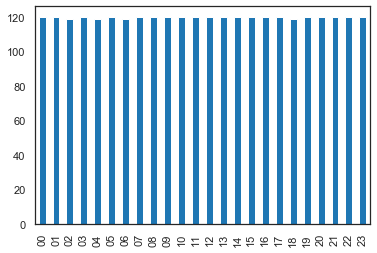

In [48]:
# plot number of files per hour in 2.8 (should be ~120 files per hour)
files_28 = [os.path.basename(x) for x in Path(siri_28_dir).rglob('*.json')]  # recursive search
print(len(files_28))

files_hour_28 = [x.split('-14T')[1].split('.')[0][:2] for x in files_28]
pd.Series(files_hour_28).value_counts().sort_index().plot.bar()
plt.show()


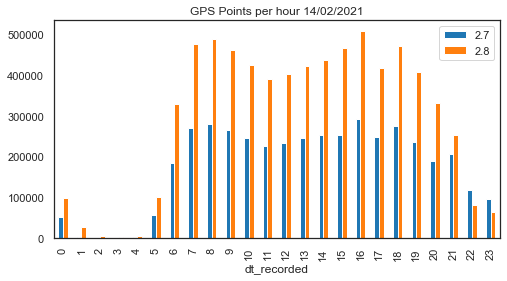

In [51]:
# Points per hour
hour_27 = df_27_day_dedup.groupby(df_27_day_dedup.dt_recorded.dt.hour).size().rename('2.7')
hour_28 = df_28_day_dedup.groupby(df_28_day_dedup.recorded_at_time.dt.hour).size().rename('2.8')

hour_27.to_frame().join(hour_28).plot.bar(figsize=(8, 4))
plt.title('GPS Points per hour 14/02/2021')
plt.show()

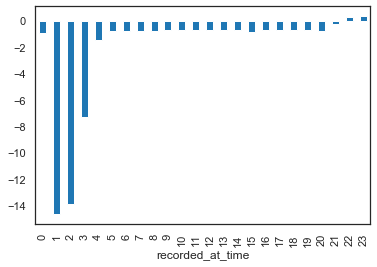

In [52]:
(1 - (hour_28/hour_27)).plot.bar(figsize=(6, 4))
plt.show()

In [53]:
hour_28.sum() / hour_27.sum()

1.6727601725977823

2.8 has more GPS points than 2.7 in most hours.

## GPS points comparison

In [54]:
# When grouping by agency
agency_27 = df_27_day_dedup.groupby('agency_id').size().rename('2.7')
agency_28 = df_28_day_dedup.groupby('operator_ref').size().rename('2.8')


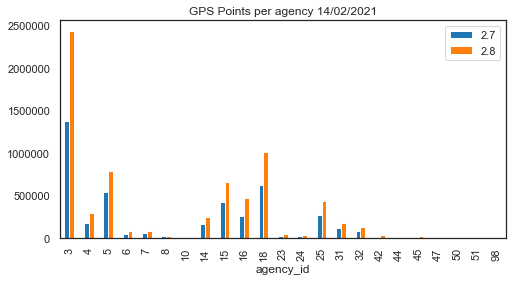

In [59]:
agency_27.to_frame().join(agency_28).plot.bar(figsize=(8, 4))
plt.title('GPS Points per agency 14/02/2021')

plt.show()

In [60]:
(1 - (agency_28/agency_27)).sort_values()

98   -1.653846
10   -1.020968
42   -1.016846
47   -1.015707
44   -1.001181
45   -0.989963
50   -0.985619
51   -0.985234
24   -0.950291
23   -0.839933
16   -0.796893
3    -0.775213
6    -0.660614
4    -0.652663
25   -0.631471
18   -0.615777
32   -0.579101
15   -0.562720
31   -0.542488
7    -0.531638
14   -0.503967
5    -0.467410
8    -0.450949
2          NaN
91         NaN
94         NaN
97         NaN
dtype: float64

## Rides comparison

In [61]:
df_27_final_rides.shape[0], df_28_final_rides.shape[0]

(98733, 96027)

In [62]:
df_28_final_rides.shape[0] / df_27_final_rides.shape[0]

0.9725927501443287

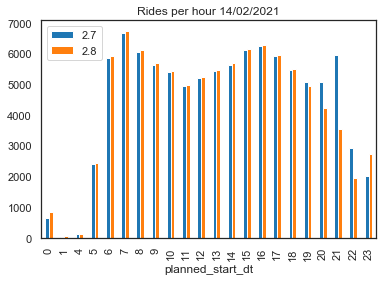

In [63]:
# Points per hour
hour_27_r = df_27_final_rides.groupby(
    df_27_final_rides.planned_start_dt.dt.hour).size().rename('2.7')
hour_28_r = df_28_final_rides.groupby(
    df_28_final_rides.origin_aimed_departure_time.dt.hour)\
    .size().rename('2.8')

hour_27_r.to_frame().join(hour_28_r).plot.bar(figsize=(6, 4))
plt.title('Rides per hour 14/02/2021')
plt.show()

In [64]:
# When grouping by agency
agency_27_r = df_27_final_rides.groupby('agency_id').size().rename('2.7')
agency_28_r = df_28_final_rides.groupby('operator_ref').size().rename('2.8')


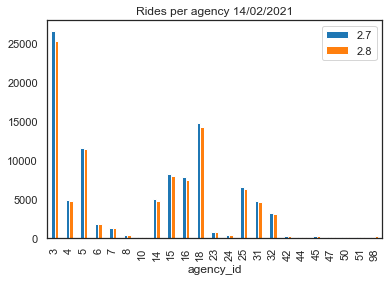

In [66]:
agency_27_r.to_frame().join(agency_28_r).plot.bar(figsize=(6, 4))
plt.title('Rides per agency 14/02/2021')

plt.show()

In [67]:
(1 - (agency_28_r / agency_27_r)).sort_values()

98   -0.508475
7    -0.070732
23   -0.015424
6    -0.004582
50    0.000000
10    0.000000
51    0.000000
5     0.005812
47    0.006369
45    0.008264
42    0.011858
44    0.012821
8     0.017995
24    0.021978
4     0.030084
15    0.031327
32    0.033963
31    0.038389
18    0.040584
14    0.043400
16    0.046556
25    0.047012
3     0.051129
2          NaN
91         NaN
94         NaN
97         NaN
dtype: float64

In [68]:
routes_27 = set(df_27_final_rides[df_27_final_rides.points_cnt > 10]
                .route_id.values)
routes_28 = set(df_28_final_rides[df_28_final_rides.points_cnt > 10]
                .line_ref.values)

missing_routes_no28_yes27 = routes_27 - routes_28

extra_routes_no27_yes28 = routes_28 - routes_27

print("Number of route ids with at least 1 ride of 10 points:",
      "Siri 2.7: {}".format(len(routes_27)),
      "Siri 2.8: {}".format(len(routes_28)),
      "Missing routes (appear in 2.7 but not in 2.8): {}".format( 
      len(missing_routes_no28_yes27)),
      "Extra routes (appear in 2.8 but not in 2.7): {}".format( 
      len(extra_routes_no27_yes28)),
     sep='\n\t')

Number of route ids with at least 1 ride of 10 points:
	Siri 2.7: 5167
	Siri 2.8: 5234
	Missing routes (appear in 2.7 but not in 2.8): 138
	Extra routes (appear in 2.8 but not in 2.7): 205


In [69]:
routes_27 = set(df_27_final_rides.route_id.values)
routes_27 = {int(x) for x in routes_27} # cast for json serializability
routes_28 = set(df_28_final_rides.line_ref.values)
routes_28 = {int(x) for x in routes_28} # cast for json serializability

missing_routes_no28_yes27 = routes_27 - routes_28

extra_routes_no27_yes28 = routes_28 - routes_27

print("Number of route ids:",
      "Siri 2.7: {}".format(len(routes_27)),
      "Siri 2.8: {}".format(len(routes_28)),
      "Missing routes (appear in 2.7 but not in 2.8): {}".format( 
      len(missing_routes_no28_yes27)),
      "Extra routes (appear in 2.8 but not in 2.7): {}".format( 
      len(extra_routes_no27_yes28)),
     sep='\n\t')


routes_dict = {
    'routes_2.7': sorted(list(routes_27)),
    'routes_2.8': sorted(list(routes_28)),
    'missing_routes_no2.8_yes2.7': sorted(list(missing_routes_no28_yes27)),
    'extra_routes_no2.7_yes2.8': sorted(list(extra_routes_no27_yes28)),
}

with open('route_ids_siri_27_28.json', 'w') as f:
    json.dump(routes_dict, f, indent=2)
    print(dt.datetime.now(), "json saved for all route ids")

Number of route ids:
	Siri 2.7: 5333
	Siri 2.8: 5316
	Missing routes (appear in 2.7 but not in 2.8): 153
	Extra routes (appear in 2.8 but not in 2.7): 136
2021-02-16 22:01:54.789416 json saved for all route ids


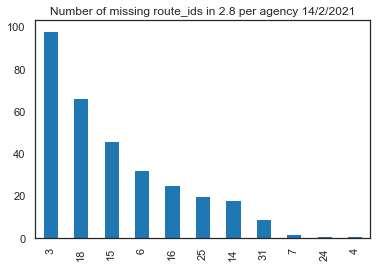

In [78]:
# missing routes per agency:
df_27_final_rides[df_27_final_rides.route_id.isin(missing_routes_no28_yes27)]\
    .agency_id.value_counts().plot.bar()
plt.title("Number of missing route_ids in 2.8 per agency 14/2/2021")
plt.show()

In [71]:
# missing routes with most rides in 2.7:
df_27_final_rides[df_27_final_rides.route_id.isin(missing_routes_no28_yes27)]\
    .groupby('route_id').size().sort_values(ascending=False).head(10).to_frame().rename(columns={0: 'N_rides_in_2.7'})


,N_rides_in_2.7
route_id,
1315,7
11332,7
1106,7
7698,7
7927,7
7831,7
7843,6
11301,6
7873,6


In [72]:
# df_27_final_dedup[df_27_final_dedup.route_id == 26010].sort_values('dt_recorded')

In [74]:
# Do the missing rides belong to the missing routes?
agency_27_r2 = df_27_final_rides[
    ~df_27_final_rides.route_id.isin(missing_routes_no28_yes27)]\
    .groupby('agency_id').size().rename('2.7')


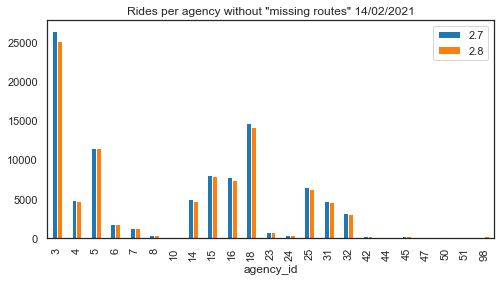

In [77]:
agency_27_r2.to_frame().join(agency_28_r).plot.bar(figsize=(8, 4))
plt.title('Rides per agency without "missing routes" 14/02/2021')

plt.show()

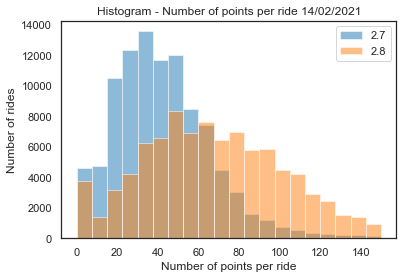

In [81]:
# number of points per ride:
fig, ax = plt.subplots(1,1)

df_27_final_rides.points_cnt.hist(bins=20, ax=ax, alpha=0.5, 
                                  label='2.7', range=(0, 150))
df_28_final_rides.points_cnt.hist(bins=20, ax=ax, alpha=0.5, 
                                  label='2.8', range=(0, 150))

plt.legend()
plt.grid(False)
plt.xlabel('Number of points per ride')
plt.ylabel('Number of rides')
plt.title('Histogram - Number of points per ride 14/02/2021')
plt.show()